### 1. Load dataset from .pkl file

In [2]:
from utils import load_dataset
image_width,image_height=50,50
# classes=['air-hole', 'hollow-bead', 'slag-inclusion', 'bite-edge', 'broken-arc', 'crack', 'overlap', 'unfused']
(train_labels,train_images),(test_labels,test_images)=load_dataset(resize=(image_width,image_height),onehot=False,normalize=False)

# print(train_images.shape,len(train_labels))
# (5404, 50, 50) 5404

### 2. Preview some samples from dataset

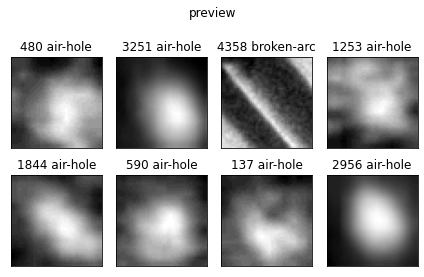

In [5]:
import matplotlib.pyplot as plt
import numpy as np

preview_index=np.random.randint(len(train_labels),size=8)
fig=plt.figure()
for i in range(preview_index.size):
    sp=fig.add_subplot(2,4,i+1,xticks=[],yticks=[])
    sp.imshow(train_images[preview_index[i]],cmap='gray')
    sp.set_title(str(preview_index[i])+' '+train_labels[preview_index[i]])

fig.tight_layout(h_pad=1)
fig.suptitle('preview')
plt.subplots_adjust(top=0.85)
plt.show()

### 3. Load dataset from .csv file

In [6]:
import pandas as pd

label_names=['air-hole', 'bite-edge', 'broken-arc', 'crack', 'hollow-bead', 'overlap', 'slag-inclusion', 'unfused']
df=pd.read_csv('./dataset.csv',index_col=0)
df.head(3)

image_name  image_width  image_height  center_x  \
0  air-hole12(hollow-bead)-142.jpg         1178           817  0.956706   
1  air-hole12(hollow-bead)-142.jpg         1178           817  0.448217   
2                air-hole7-028.jpg         1182           816  0.427665   

   center_y  bnd_width  bnd_height  label  
0  0.954100   0.016978    0.020808      0  
1  0.256426   0.049236    0.052632      4  
2  0.389093   0.010998    0.018382      0

### 4. Attempt figure out some correlation

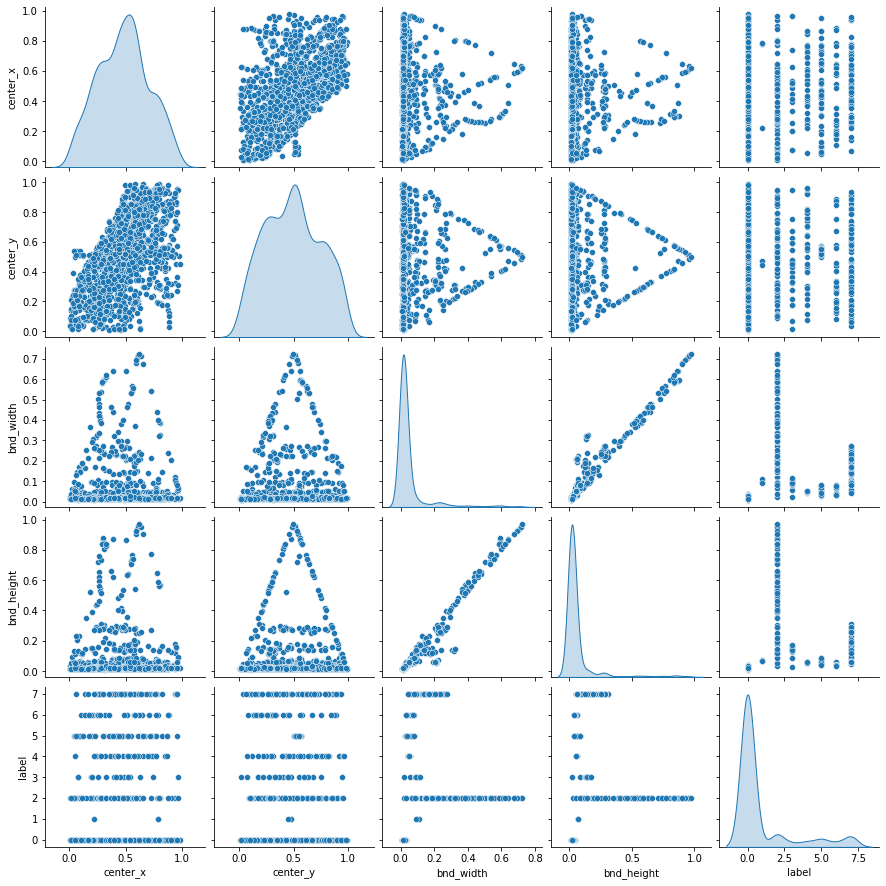

In [7]:
def preprocess_dataset(dataset):
    dataset = dataset.copy()
    dataset.drop('image_name',axis=1,inplace=True)
    dataset.drop('image_width',axis=1,inplace=True)
    dataset.drop('image_height',axis=1,inplace=True)
    dataset.dropna(inplace=True)
    dataset.drop_duplicates(inplace=True)

    train_dataset = dataset.sample(frac=0.8, random_state=0)
    test_dataset = dataset.drop(train_dataset.index)
    return train_dataset, test_dataset

train_dataset, test_dataset=preprocess_dataset(df)
import seaborn as sns
sns_plot = sns.pairplot(test_dataset[['center_x','center_y','bnd_width','bnd_height','label']], diag_kind="kde")
# 1. 样本分布不均，air-hole样本占比较大
# 2. bnd_width 和 bnd_height正相关
# 3. 中心点被限制在bounding box之内

<AxesSubplot:xlabel='label'>

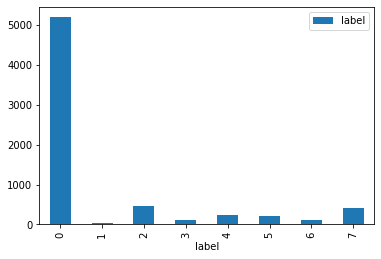

In [11]:
df[['label']].groupby('label').agg({'label':'count'}).plot(kind='bar')

### 5. LinearRegression with sklearn

In [208]:
from sklearn.model_selection import train_test_split
def preprocess_dataset2(dataset):
    dataset = dataset.copy()
    dataset.drop('image_name',axis=1,inplace=True)
    dataset.drop('image_width',axis=1,inplace=True)
    dataset.drop('image_height',axis=1,inplace=True)
    dataset.dropna(inplace=True)
    dataset.drop_duplicates(inplace=True)
    return train_test_split(dataset[['bnd_width','label']],dataset['bnd_height'],test_size=0.3)

x_train,x_test,y_train,y_test= preprocess_dataset2(df)
# print(x_train.shape,x_test.shape)
from sklearn.linear_model import LinearRegression
reg=LinearRegression().fit(x_train,y_train)
print(reg.score(x_test, y_test))

# print(reg.predict(x_test[2:3]),y_test[2])
# [0.01780349] 0.0183823529411764
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_test, reg.predict(x_test)))

0.9515690188669116
0.000866723870228876


### 6. LogisticRegression with sklearn

|  Evaluation   | Formula  |
|  ----  | ----  |
| precision  | $\mathrm{P}=\frac{T P}{T P+F P}$ |
| recall  | $\mathrm{R}=\frac{T P}{T P+F N}$ |
| f1 score  | $\mathrm{F} 1=\frac{2 \times P \times R}{P+R}$ |

*tips: lr.score是使用average='micro'的[f1_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)*

In [224]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

def preprocess_dataset3(dataset):
    dataset = dataset.copy()
    dataset.drop('image_name',axis=1,inplace=True)
    dataset.drop('image_width',axis=1,inplace=True)
    dataset.drop('image_height',axis=1,inplace=True)
    dataset.dropna(inplace=True)
    dataset.drop_duplicates(inplace=True)
    return dataset.drop('label',axis=1),dataset['label']

X,y=preprocess_dataset3(df)
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
skf.get_n_splits(X,y)
# print(skf)
lr=LogisticRegression()
for train_index, test_index in skf.split(X,y):
    # print("TRAIN:", len(train_index), "TEST:", len(test_index))
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    lr.fit(X_train, y_train)
    print(lr.score(X_test, y_test),f1_score(y_test,lr.predict(X_test),average='weighted'))

0.8407079646017699 0.7906586443666229
0.8377581120943953 0.7884978432533695
0.8362831858407079 0.7860010979271665
0.8303834808259587 0.7797341608849924
0.8348082595870207 0.7830430272603349
0.8478581979320532 0.7981489595279804
0.8389955686853766 0.7884098006946487
0.8478581979320532 0.7971643605655561
0.8419497784342689 0.7915714010915801
0.8493353028064993 0.7998582076370572


### 7. Related Work
1. [Implementation of R-CNN](https://github.com/huangyebiaoke/R-CNN)
2. [yolov5-exp-report.pdf](./yolov5-exp-report.pdf)